# Summarization Comparison
Imports necessary libraries. For this project I'm going to be using pytorch instead of tensorflow.

In [1]:
!pip install -U transformers
#!pip install bert-extractive-summarizer

     |████████████████████████████████| 884 kB 191 kB/s 
     |████████████████████████████████| 3.0 MB 5.2 MB/s 
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.7.0
    Uninstalling tokenizers-0.7.0:
      Successfully uninstalled tokenizers-0.7.0
  Attempting uninstall: transformers
    Found existing installation: transformers 2.11.0
    Uninstalling transformers-2.11.0:
      Successfully uninstalled transformers-2.11.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

allennlp 1.0.0 requires transformers<2.12,>=2.9, but you'll have transformers 3.1.0 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelWithLMHead
import torch
import pandas as pd
import time

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
import transformers
print(transformers.__version__)

3.1.0


In [4]:
#from transformers import pipeline; print(pipeline('sentiment-analysis')('I hate you'))

### Read in Data
Reads in the 3 csv files, drops unneeded columns, then concatenates them together. 

In [5]:
df_1 = pd.read_csv('../input/all-the-news/articles1.csv')
df_2 = pd.read_csv('../input/all-the-news/articles2.csv')
df_3 = pd.read_csv('../input/all-the-news/articles3.csv')
dfs = [df_1, df_2, df_3]
for frame in dfs:
    frame.drop(columns=['Unnamed: 0', 'publication', 'author', 'date', 'month', 'url'], axis=1, inplace=True)
df = pd.concat(dfs)

In [6]:
df.head()

,id,title,year,content
0,17283,House Republicans Fret About Winning Their Hea...,2016.0,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,2017.0,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",2017.0,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",2017.0,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,2017.0,"SEOUL, South Korea — North Korea’s leader, ..."


In [7]:
df.describe

<bound method NDFrame.describe of            id                                              title    year  \
0       17283  House Republicans Fret About Winning Their Hea...  2016.0   
1       17284  Rift Between Officers and Residents as Killing...  2017.0   
2       17285  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...  2017.0   
3       17286  Among Deaths in 2016, a Heavy Toll in Pop Musi...  2017.0   
4       17287  Kim Jong-un Says North Korea Is Preparing to T...  2017.0   
...       ...                                                ...     ...   
42566  218078  An eavesdropping Uber driver saved his 16-year...  2016.0   
42567  218079  Plane carrying six people returning from a Cav...  2016.0   
42568  218080  After helping a fraction of homeowners expecte...  2016.0   
42569  218081  Yes, this is real: Michigan just banned bannin...  2016.0   
42570  218082  What happened in Washington state after voters...  2016.0   

                                                 cont

## Summarizing Using Different Models

Used different models through huggingface's transformers

### T5

In [8]:
model = AutoModelForSeq2SeqLM.from_pretrained('t5-base')
tokenizer = AutoTokenizer.from_pretrained("t5-base")

In [9]:
start = time.time()
inputs = tokenizer.encode("summarize: " + df.iloc[0]['content'], return_tensors="pt", max_length=512)
outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
decoded_T5 = tokenizer.decode(outputs[0])
end = time.time()
t5_time = (end - start)
print(t5_time)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


14.926549673080444


### BERT

In [10]:
model = AutoModelWithLMHead.from_pretrained('bert-base-cased')
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

/opt/conda/lib/python3.7/site-packages/transformers/modeling_auto.py:821: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
start = time.time()
inputs = tokenizer.encode("summarize: " + df.iloc[0]['content'], return_tensors="pt", max_length=100)
outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
decoded_BERT = tokenizer.decode(outputs[0])
end = time.time()
BERT_time = (end-start)
print(BERT_time)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


47.95914030075073


### GPT 

In [12]:
model = AutoModelWithLMHead.from_pretrained('openai-gpt')
tokenizer = AutoTokenizer.from_pretrained("openai-gpt")

Some weights of OpenAIGPTLMHeadModel were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [13]:
start = time.time()
inputs = tokenizer.encode("summarize: " + df.iloc[0]['content'], return_tensors="pt", max_length=149)
outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
decoded_GPT = tokenizer.decode(outputs[0])
end = time.time()
GPT_time = (end - start)
print(GPT_time)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1.3909220695495605


### DistilBERT

In [14]:
model = AutoModelWithLMHead.from_pretrained('distilgpt2')
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")

In [15]:
start = time.time()
inputs = tokenizer.encode("summarize: " + df.iloc[0]['content'], return_tensors="pt", max_length=149)
outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
decoded_DistilBERT = tokenizer.decode(outputs[0])
end = time.time()
DistilBERT_time = (end - start)
print(DistilBERT_time)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0.9538519382476807


### GPT2

In [16]:
model = AutoModelWithLMHead.from_pretrained('gpt2')
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [17]:
start = time.time()
inputs = tokenizer.encode("summarize: " + df.iloc[0]['content'], return_tensors="pt", max_length=149)
outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
decoded_GPT2 = tokenizer.decode(outputs[0])
end = time.time()
GPT2_time = (end - start)
print(GPT2_time)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1.3679282665252686


### T5 Trained on Wikihow

In [18]:
model = AutoModelForSeq2SeqLM.from_pretrained("deep-learning-analytics/wikihow-t5-small")
tokenizer = AutoTokenizer.from_pretrained("deep-learning-analytics/wikihow-t5-small")

In [19]:
start = time.time()
inputs = tokenizer.encode("summarize: " + df.iloc[0]['content'], return_tensors="pt", max_length=1024)
outputs = model.generate(inputs, max_length=200, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
decoded_T5_wikihow = tokenizer.decode(outputs[0])
end = time.time()
t5_wikihow_time = (end - start)
print(t5_wikihow_time)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


6.675548791885376


### Pegasus NewsRoom

In [20]:
model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-newsroom")
tokenizer = AutoTokenizer.from_pretrained("google/pegasus-newsroom")

In [21]:
start = time.time()
batch = tokenizer.prepare_seq2seq_batch(df['content'].tolist()[:1], max_target_length=200, padding='longest')
translated = model.generate(**batch)
tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
end = time.time()
decoded_pegasus_newsroom = tgt_text[0]
pegasus_newsroom_time = (end - start)
print(pegasus_newsroom_time)

31.211305379867554


### Pegasus CNN Daily Mail

In [22]:
tokenizer = AutoTokenizer.from_pretrained("google/pegasus-cnn_dailymail")
model = AutoModelWithLMHead.from_pretrained("google/pegasus-cnn_dailymail")

Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
start = time.time()
batch = tokenizer.prepare_seq2seq_batch(df['content'].tolist()[:1], max_target_length=200, padding='longest')
translated = model.generate(**batch)
tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
end = time.time()
decoded_pegasus_cnn = tgt_text[0]
pegasus_cnn_time = (end - start)
print(pegasus_cnn_time)

72.40552091598511


## Results Analysis

In [24]:
decoded_BERT

'[CLS] summarize : WASHINGTON — Congressional Republicans have a new fear when it comes to their health care lawsuit against the Obama administration : They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration ’ s authority to spend billions of dollars on health insurance subsidies for and Americans, handing House Republicans a big victory on issues. But a sudden loss of the disputed subsidies could conceivably cause the health care [SEP] If - - - - - - - - - - - - that the situation changes when - - - - - - - - - - - - - - - - - If the situation changes, the situation changes. - - - - - -'

In [25]:
decoded_T5

'a sudden loss of the disputed subsidies could conceivably cause the health care program to implode. that could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. the incoming Trump administration could choose to no longer defend the executive branch against the suit.'

In [26]:
decoded_DistilBERT

'summarize: WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government.'

In [27]:
decoded_GPT

'summarize : washington <unk>congressional republicans have a new fear when it comes to their health care lawsuit against the obama administration : they might win. the incoming trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration <unk>s authority to spend billions of dollars on health insurance subsidies for and americans, handing house republicans a big victory on issues. but a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before republicans have prepared a replacement. that could lead to chaos in the insurance market and spur a political backlash just as republicans gain full control of the government. to stave off that outcome, republicans could find a'

In [28]:
decoded_DistilBERT

'summarize: WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government.'

In [29]:
decoded_T5_wikihow

'Defend the health care lawsuit against the Obama administration.Consider a halt in the case.Consider a halt in the case.Consider a halt in the case.Consider a halt in the case.Consider a halt in the case.'

In [30]:
decoded_GPT2

'summarize: WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government.'

In [31]:
decoded_pegasus_newsroom

'Congressional Republicans have a new fear when it comes to their health care lawsuit against the Obama administration: They might win.'

In [32]:
decoded_pegasus_cnn

'The incoming Trump administration could choose to no longer defend the executive branch against the suit.<n>A sudden loss of the disputed subsidies could conceivably cause the health care program to implode.<n>Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law.'

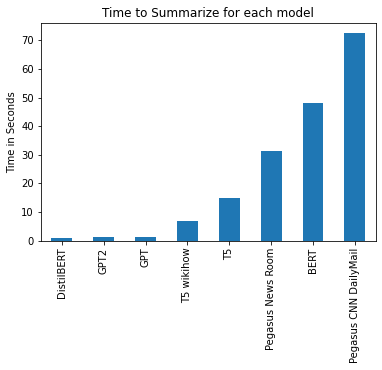

In [33]:
import matplotlib.pyplot as plot
time_array = {'Model': ["BERT", "T5", "DistilBERT", "GPT", "GPT2", "T5 wikihow", "Pegasus News Room", "Pegasus CNN DailyMail"], 'Times': [BERT_time, t5_time, DistilBERT_time, GPT_time, GPT2_time, t5_wikihow_time, pegasus_newsroom_time, pegasus_cnn_time]}
df_time = pd.DataFrame(data=time_array)
df_time.sort_values('Times').plot.bar(x="Model", y="Times", title="Time to Summarize for each model", ylabel="Time in Seconds", xlabel="", legend=False)
plot.show()

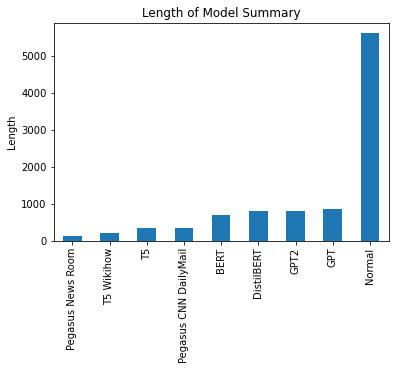

In [34]:
length_dict = {"Model": ["Normal", "BERT", "T5", "DistilBERT", "GPT", "GPT2", "T5 Wikihow", "Pegasus News Room", "Pegasus CNN DailyMail"], "Length": [(len(df.iloc[0]['content'])), (len(decoded_BERT)), (len(decoded_T5)), (len(decoded_DistilBERT)), (len(decoded_GPT)), (len(decoded_GPT2)), (len(decoded_T5_wikihow)), (len(decoded_pegasus_newsroom)), (len(decoded_pegasus_cnn))]}
df_length = pd.DataFrame(data=length_dict)
df_length.sort_values('Length').plot.bar(x="Model", y="Length", title="Length of Model Summary", ylabel="Length", xlabel="", legend=False)
plot.show()